# Credit risk prediction 

### In this notebook I will explore data and different ways to figure out missing data problem, also I will built a Logistic Regression prediction and evaluate results with roc_auc.

In [25]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

customer = pd.read_csv('customer_data.csv')

Customer’s demographic data and category attributes which have been encoded<br><br>
Category features: fea1, fea3, fea5, fea6, fea7, fea9, fea10, fea11<br><br>
label is 1, the customer is in high credit risk<br>
label is 0, the customer is in low credit risk<br>

In [26]:
customer.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [27]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
label     1125 non-null int64
id        1125 non-null int64
fea_1     1125 non-null int64
fea_2     976 non-null float64
fea_3     1125 non-null int64
fea_4     1125 non-null float64
fea_5     1125 non-null int64
fea_6     1125 non-null int64
fea_7     1125 non-null int64
fea_8     1125 non-null int64
fea_9     1125 non-null int64
fea_10    1125 non-null int64
fea_11    1125 non-null float64
dtypes: float64(3), int64(10)
memory usage: 114.4 KB


In [28]:
with_missing_values = customer.copy()

## Task 1

We have missed values in fea_2. Let`s look at the distribution 

In [29]:
customer.fea_2.describe()

count     976.000000
mean     1283.911373
std        51.764022
min      1116.500000
25%      1244.000000
50%      1281.500000
75%      1314.500000
max      1481.000000
Name: fea_2, dtype: float64

<AxesSubplot:xlabel='fea_2', ylabel='Density'>

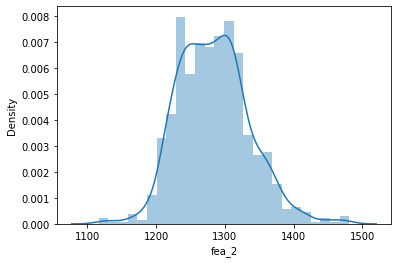

In [30]:
import seaborn as sns

sns.distplot(customer.fea_2)

That looks like a noramal distributuion with mean 1283.9, so fill missed values with 1283.9

In [31]:
customer.fea_2 = customer.fea_2.fillna(customer.fea_2.mean()) 

In [32]:
customer.fea_2.describe()

count    1125.000000
mean     1283.911373
std        48.211113
min      1116.500000
25%      1250.000000
50%      1283.911373
75%      1310.000000
max      1481.000000
Name: fea_2, dtype: float64

In [33]:
without_missing_values = customer.copy()

## Task 2

We are going to create randomly miss values 5% 10% 15%, fill it with median value, KNN approach and check result by rmse metric 

We are going to play with fea_2 and fea_6

In [10]:
customer.fea_6.describe()

count    1125.000000
mean       10.872000
std         2.676437
min         3.000000
25%         8.000000
50%        11.000000
75%        11.000000
max        16.000000
Name: fea_6, dtype: float64

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.impute import KNNImputer

def count( my_data, name, percent):
    
    my_data.loc[my_data.sample(frac=percent).index, name] = pd.np.nan # add missed values
    data2 = my_data.copy()
    
    my_data[name] = my_data[name].fillna(my_data[name].median()) # fill by median
    
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    X = data2.values
    X1 = imputer.fit_transform(X) #fill by KNNinputer
    return sqrt(mean_squared_error( customer[name],  my_data[name])),  sqrt(mean_squared_error( customer[name],  X1[:,list(data2.columns).index(name)])) 

    
    
    

In [12]:
customer = customer.drop(columns = ['id']) # We have to drop it for better quality of KNNImputer

In [13]:
for name in ['fea_4', 'fea_6']:
    for per in [0.05, 0.1, 0.15]:
        
        rmse_list_median = []
        rmse_list_knn = []

        for i in range(1000): # for confident result
            median, knn = count( customer.copy(), name, per)
            rmse_list_median.append(median)
            rmse_list_knn.append(knn)

        print( f'rmse({per*100}%, {name}, median) = {np.array(rmse_list_median).mean()}')
        print( f'rmse({per*100}%, {name}, knn) = {np.array(rmse_list_knn).mean()}')
    print('+++++++++++++++++++++++++++++++++++++++++++++')

rmse(5.0%, fea_4, median) = 19565.01819472568
rmse(5.0%, fea_4, knn) = 19977.2466422597
rmse(10.0%, fea_4, median) = 27523.431990692916
rmse(10.0%, fea_4, knn) = 28225.765672881884
rmse(15.0%, fea_4, median) = 34882.455188289
rmse(15.0%, fea_4, knn) = 35356.467054937915
+++++++++++++++++++++++++++++++++++++++++++++
rmse(5.0%, fea_6, median) = 0.5958471512572774
rmse(5.0%, fea_6, knn) = 0.6340325467262458
rmse(10.0%, fea_6, median) = 0.8438398863320118
rmse(10.0%, fea_6, knn) = 0.9040069852450356
rmse(15.0%, fea_6, median) = 1.0366727471858028
rmse(15.0%, fea_6, knn) = 1.1132457867232344
+++++++++++++++++++++++++++++++++++++++++++++


Conclusion. The best result was showed by median inputs.

## Task 3 (modify)

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

print('fea_4' )
print( customer.fea_4.describe() )
print('fea_10' )
print( customer.fea_10.describe() )

customer[['fea_4', 'fea_10']] = scaler.fit_transform(customer[['fea_4', 'fea_10']])

print( "After scaling")
print('fea_4' )
print( customer.fea_4.describe() )
print('fea_10' )
print( customer.fea_10.describe() )

fea_4
count    1.125000e+03
mean     1.208836e+05
std      8.844523e+04
min      1.500000e+04
25%      7.200000e+04
50%      1.020000e+05
75%      1.390000e+05
max      1.200000e+06
Name: fea_4, dtype: float64
fea_10
count      1125.000000
mean     164618.495111
std      152520.488281
min       60000.000000
25%       60044.000000
50%       72000.000000
75%      151307.000000
max      650070.000000
Name: fea_10, dtype: float64
After scaling
fea_4
count    1125.000000
mean        0.089353
std         0.074637
min         0.000000
25%         0.048101
50%         0.073418
75%         0.104641
max         1.000000
Name: fea_4, dtype: float64
fea_10
count    1125.000000
mean        0.177298
std         0.258479
min         0.000000
25%         0.000075
50%         0.020337
75%         0.154739
max         1.000000
Name: fea_10, dtype: float64


In [35]:
normalized = customer.copy()

## Lab3

We have 3 different variants of our dataset now: with missing values, without missing values, normalized(without missing values). We will make trustability(1 and 0 values, first column) forecast. Let's discover informativeness of data with the help of RFE.

In [1]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def rfe_test(df, n_features_to_select, step, variables, result):

    model = LogisticRegression()
    selector = RFE(model, n_features_to_select, step)
    selector = selector.fit(df[variables], df[result])
    print(selector.support_)
    print(selector.ranking_)

In [48]:
rfe_test(normalized, 4, 1, ['fea_1','fea_2', 'fea_3','fea_4','fea_5','fea_6',
                                      'fea_7','fea_8','fea_9','fea_10','fea_11'],'label')

[ True False  True  True False False False False False  True False]
[1 8 1 1 7 2 4 5 3 1 6]


Also let's define feature importance with Extra Trees Classifier

In [49]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(normalized[['fea_1','fea_2', 'fea_3','fea_4','fea_5','fea_6',
                                      'fea_7','fea_8','fea_9','fea_10','fea_11']], without_missing_values['label'])
print(model.feature_importances_)

[0.02504515 0.14493723 0.03208062 0.19161454 0.01396175 0.02437203
 0.06206993 0.15474169 0.06754135 0.15976517 0.12387054]


Most important features with ExtraTreesClassifier: 4, 10, 8, 2, 11

Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(normalized[['fea_1','fea_2', 'fea_3','fea_4','fea_5','fea_6',
                                      'fea_8','fea_9','fea_10','fea_11']], without_missing_values['label'])
numpy.set_printoptions(precision=3)
print(fit.scores_)

[1.064e+00 1.066e+01 1.152e+00 1.211e+00 1.152e-02 6.188e-01 7.238e-01
 0.000e+00 3.286e-04 6.309e-01]


Most important features with Chi-squared: 2, 4, 3, 1, 9

In [56]:
data = {'Features': ['fea_1','fea_2', 'fea_3','fea_4','fea_5','fea_6',
                                      'fea_7','fea_8','fea_9','fea_10','fea_11'],

'RFE': [1,0,1,1,0,0,0,0,0,1,0],

'Trees': [0,1,0,1,0,0,0,1,0,1,1],
'Chi-squared': [1,1,1,1,0,0,0,0,1,0,0]}

scores = pd.DataFrame(data, columns=['Features', 'RFE', 'Trees', 'Chi-squared'])

In [58]:
scores['Sum'] = scores['RFE'] + scores['Trees'] + scores['Chi-squared']
scores['Important'] = np.where(scores['Sum'] >= 2, True, False)

In [59]:
scores

,Features,RFE,Trees,Chi-squared,Sum,Important
0,fea_1,1,0,1,2,True
1,fea_2,0,1,1,2,True
2,fea_3,1,0,1,2,True
3,fea_4,1,1,1,3,True
4,fea_5,0,0,0,0,False
5,fea_6,0,0,0,0,False
6,fea_7,0,0,0,0,False
7,fea_8,0,1,0,1,False
8,fea_9,0,0,1,1,False
9,fea_10,1,1,0,2,True


Leave only features with sum of scores more than 2: fea_1, fea_2, fea_3, fea_4, fea_10

In [61]:
normalized['label'].value_counts()

0    900
1    225
Name: label, dtype: int64

So we have ratio 80/20

In [70]:
with_missing_values = with_missing_values[['label','fea_1','fea_2', 'fea_3','fea_4','fea_10']]
without_missing_values = without_missing_values[['label','fea_1','fea_2', 'fea_3','fea_4','fea_10']]
normalized = normalized[['label','fea_1','fea_2', 'fea_3','fea_4','fea_10']]

### 50/50 relation

##### With missing values

In [105]:
with_missing_values['fea_2'] = np.where(with_missing_values['fea_2'].isna(), 0, with_missing_values['fea_2'])

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(with_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    with_missing_values['label'], test_size=0.5, train_size=0.5, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [144]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [147]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       461
           1       0.00      0.00      0.00       102

    accuracy                           0.82       563
   macro avg       0.41      0.50      0.45       563
weighted avg       0.67      0.82      0.74       563



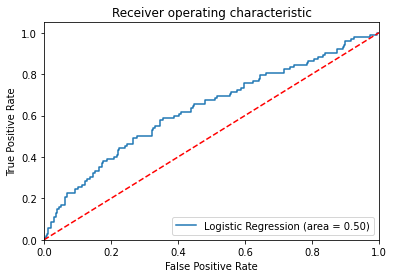

In [149]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


##### Without missing values

In [153]:
X_train, X_test, y_train, y_test = train_test_split(without_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    without_missing_values['label'], test_size=0.5, train_size=0.5, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [154]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       461
           1       0.00      0.00      0.00       102

    accuracy                           0.82       563
   macro avg       0.41      0.50      0.45       563
weighted avg       0.67      0.82      0.74       563



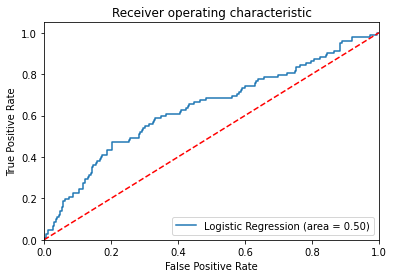

In [157]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Normalized

In [158]:
X_train, X_test, y_train, y_test = train_test_split(normalized[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    normalized['label'], test_size=0.5, train_size=0.5, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [159]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [161]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       461
           1       0.00      0.00      0.00       102

    accuracy                           0.82       563
   macro avg       0.41      0.50      0.45       563
weighted avg       0.67      0.82      0.74       563



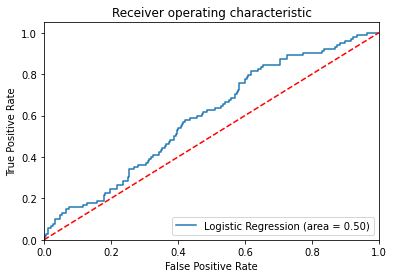

In [162]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 60/40 relation

##### With missing values

In [163]:
X_train, X_test, y_train, y_test = train_test_split(with_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    with_missing_values['label'], test_size=0.4, train_size=0.6, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [164]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       367
           1       0.00      0.00      0.00        83

    accuracy                           0.82       450
   macro avg       0.41      0.50      0.45       450
weighted avg       0.67      0.82      0.73       450



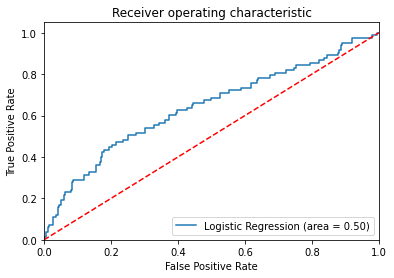

In [166]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Without missing values

In [167]:
X_train, X_test, y_train, y_test = train_test_split(without_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    without_missing_values['label'], test_size=0.4, train_size=0.6, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [168]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [169]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       367
           1       0.00      0.00      0.00        83

    accuracy                           0.82       450
   macro avg       0.41      0.50      0.45       450
weighted avg       0.67      0.82      0.73       450



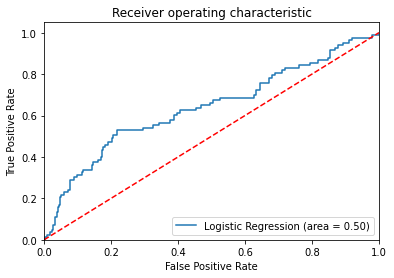

In [170]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Normalized

In [171]:
X_train, X_test, y_train, y_test = train_test_split(normalized[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    normalized['label'], test_size=0.4, train_size=0.6, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [172]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [173]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       367
           1       0.00      0.00      0.00        83

    accuracy                           0.82       450
   macro avg       0.41      0.50      0.45       450
weighted avg       0.67      0.82      0.73       450



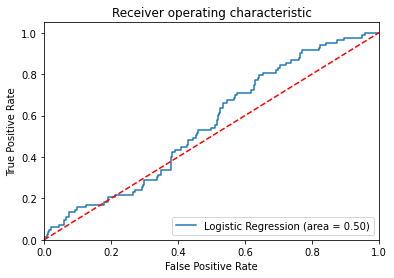

In [174]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 70/30 relation

##### With missing values

In [176]:
X_train, X_test, y_train, y_test = train_test_split(with_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    with_missing_values['label'], test_size=0.3, train_size=0.7, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [177]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [178]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       278
           1       0.00      0.00      0.00        60

    accuracy                           0.82       338
   macro avg       0.41      0.50      0.45       338
weighted avg       0.68      0.82      0.74       338



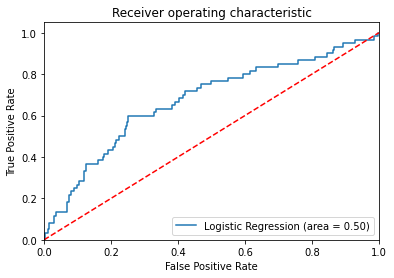

In [179]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Without missing values

In [187]:
X_train, X_test, y_train, y_test = train_test_split(without_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    without_missing_values['label'], test_size=0.3, train_size=0.7, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [188]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [189]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       278
           1       0.00      0.00      0.00        60

    accuracy                           0.82       338
   macro avg       0.41      0.50      0.45       338
weighted avg       0.68      0.82      0.74       338



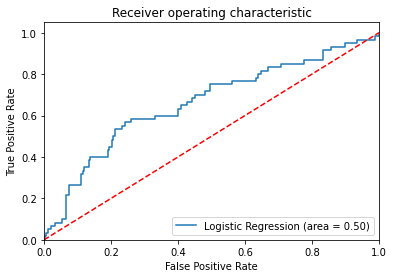

In [190]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Normalized

In [191]:
X_train, X_test, y_train, y_test = train_test_split(normalized[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    normalized['label'], test_size=0.3, train_size=0.7, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [192]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       278
           1       0.00      0.00      0.00        60

    accuracy                           0.82       338
   macro avg       0.41      0.50      0.45       338
weighted avg       0.68      0.82      0.74       338



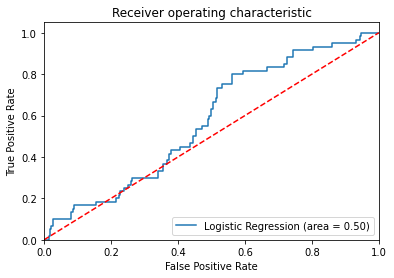

In [194]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 80/20 relation

##### With missing values

In [195]:
X_train, X_test, y_train, y_test = train_test_split(with_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    with_missing_values['label'], test_size=0.2, train_size=0.8, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [196]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [197]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       181
           1       0.00      0.00      0.00        44

    accuracy                           0.80       225
   macro avg       0.40      0.50      0.45       225
weighted avg       0.65      0.80      0.72       225



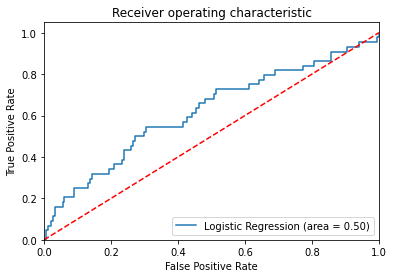

In [198]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Without missing values

In [203]:
X_train, X_test, y_train, y_test = train_test_split(without_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    without_missing_values['label'], test_size=0.2, train_size=0.8, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [204]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [205]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       181
           1       0.00      0.00      0.00        44

    accuracy                           0.80       225
   macro avg       0.40      0.50      0.45       225
weighted avg       0.65      0.80      0.72       225



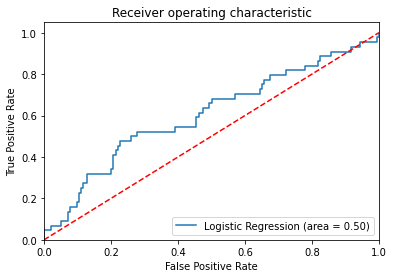

In [206]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Normalized

In [199]:
X_train, X_test, y_train, y_test = train_test_split(normalized[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    normalized['label'], test_size=0.2, train_size=0.8, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [200]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [201]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       181
           1       0.00      0.00      0.00        44

    accuracy                           0.80       225
   macro avg       0.40      0.50      0.45       225
weighted avg       0.65      0.80      0.72       225



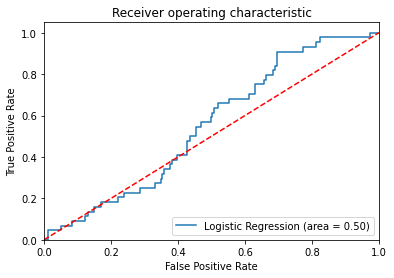

In [202]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 90/10 relation

##### With missing values

In [207]:
X_train, X_test, y_train, y_test = train_test_split(with_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    with_missing_values['label'], test_size=0.1, train_size=0.9, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [208]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [209]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        89
           1       0.00      0.00      0.00        24

    accuracy                           0.79       113
   macro avg       0.39      0.50      0.44       113
weighted avg       0.62      0.79      0.69       113



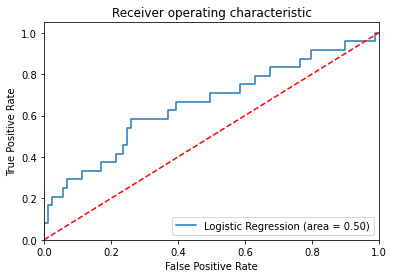

In [210]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Without missing values

In [211]:
X_train, X_test, y_train, y_test = train_test_split(without_missing_values[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    without_missing_values['label'], test_size=0.1, train_size=0.9, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [212]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [213]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        89
           1       0.00      0.00      0.00        24

    accuracy                           0.79       113
   macro avg       0.39      0.50      0.44       113
weighted avg       0.62      0.79      0.69       113



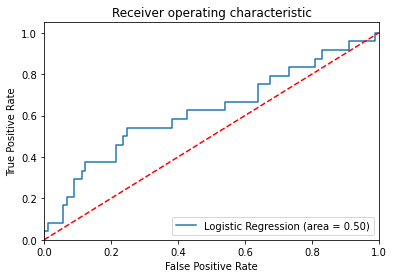

In [214]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Normalized

In [215]:
X_train, X_test, y_train, y_test = train_test_split(normalized[['fea_1','fea_2', 'fea_3','fea_4','fea_10']],
                                                    normalized['label'], test_size=0.1, train_size=0.9, random_state=0)
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)

In [216]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [217]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        89
           1       0.00      0.00      0.00        24

    accuracy                           0.79       113
   macro avg       0.39      0.50      0.44       113
weighted avg       0.62      0.79      0.69       113



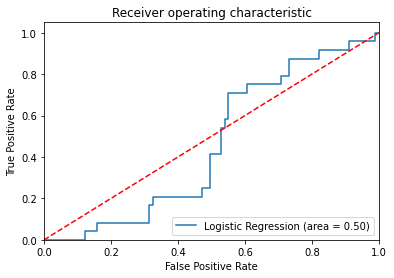

In [218]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()